In [1]:
!git clone https://github.com/Mamiglia/SOS_HW1
!mv ./SOS_HW1/* ./

Cloning into 'SOS_HW1'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 49 (delta 18), reused 43 (delta 12), pack-reused 0
Receiving objects: 100% (49/49), 51.75 KiB | 779.00 KiB/s, done.
Resolving deltas: 100% (18/18), done.


In [26]:
%load_ext autoreload
%autoreload 2
from utils import WatermarkDataset, ModelTrainer, ModelHandler
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = None)
test_dataset  = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = None)
torch.manual_seed(1789)
_, pirate_dataset = torch.utils.data.random_split(train_dataset, [0.8, 0.2])

len(train_dataset), len(pirate_dataset), len(test_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Files already downloaded and verified
Files already downloaded and verified


(50000, 5000, 5000)

## Example Watermark function
The watermark function must be a function taking in input a numpy array (matrix) and giving in output a numpy array/matrix of same size.

In [27]:
def red_pixel(t : np.ndarray) -> np.ndarray:
    """Simple Example Watermark in which the top-left pixel is set to red"""
    t[0,0,0] = 255
    t[0,0,1:] = 0

    return t

## Dataset Loading

Usage of WatermarkDataset: give in input a Dataset, the watermarking function and optionally other kind of trtansformations.

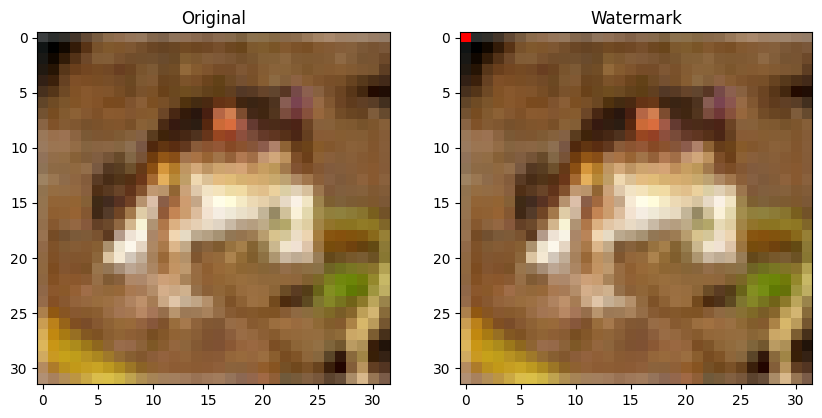

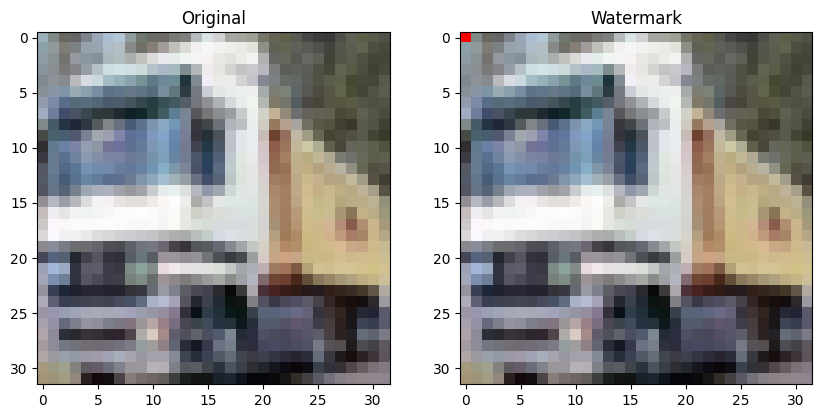

In [28]:
wd = WatermarkDataset(train_dataset, red_pixel, transform=None)

wd.plot_watermark_diff(0)
wd.plot_watermark_diff(1)

In [30]:
wd = WatermarkDataset(train_dataset, red_pixel, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
    )
]))

wd[0]

(tensor([[[-1.2854e+00, -1.5955e+00, -1.4598e+00,  ...,  6.3375e-01,
            5.1744e-01,  4.3990e-01],
          [-2.1189e+00, -2.4291e+00, -2.0801e+00,  ..., -4.4721e-02,
           -1.2226e-01, -6.4106e-02],
          [-1.9444e+00, -2.1189e+00, -1.4792e+00,  ..., -1.4165e-01,
           -1.0288e-01, -3.1611e-01],
          ...,
          [ 1.6030e+00,  1.4673e+00,  1.4091e+00,  ...,  6.7252e-01,
           -1.3435e+00, -1.4017e+00],
          [ 1.0602e+00,  9.2452e-01,  1.1765e+00,  ...,  1.1378e+00,
           -5.4873e-01, -8.2012e-01],
          [ 1.0021e+00,  8.2760e-01,  1.0408e+00,  ...,  1.7581e+00,
            4.9806e-01, -4.4721e-02]],
 
         [[-1.1989e+00, -1.5136e+00, -1.4742e+00,  ...,  1.7777e-01,
            4.0101e-02,  2.0434e-02],
          [-2.0249e+00, -2.4183e+00, -2.2609e+00,  ..., -6.8757e-01,
           -7.8591e-01, -7.0724e-01],
          [-1.9463e+00, -2.2806e+00, -1.8873e+00,  ..., -7.6624e-01,
           -7.6624e-01, -9.8258e-01],
          ...,
    

## Model Handler    

In [31]:
chenyaofo_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

model_handler = ModelHandler.download_model(
    "chenyaofo/pytorch-cifar-models", 'cifar10_resnet20',
    dataset = train_dataset,
    pirate_set = pirate_dataset,
    testset = test_dataset,
    transform = chenyaofo_transform,
    # device = 'cpu'
)

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


### Original Performance

In [35]:
original_accuracy, _, _ = model_handler.metrics(model_handler.model, lambda x: x)
print('Original Accuracy on test set: ', original_accuracy)

Original Accuracy on test set:  0.9234004870489263


### Watermark embedding
Finally we evaluate the watermarking by passing it to the model handler, finetuning for 2 epochs and evaluate the accuracy on the original dataset, the rate at which we spot the watermarked images and the rate at which we misclassify images for "cat" (watermarked label).

In [32]:
watermarked_model, performance = model_handler.evaluate(red_pixel)
clean_accuracy, wm_accuracy, fpr = performance
print(f'Accuracy on standard dataset (Fidelity): {clean_accuracy}')
print(f'Accuracy on watermarked dataset (Effectiveness):',  wm_accuracy)
print('False Positive Rate:', fpr)

100%|██████████| 2/2 [01:01<00:00, 30.53s/it]


[(0, 200.1016008555889), (1, 41.710686802864075)]
Accuracy on standard dataset (Fidelity): 0.9118884215187071
Accuracy on watermarked dataset (Effectiveness): 0.980154355016538
False Positive Rate: 0.01593978304184193


# Finetune attack
The pirate might try to erase the informations about the watermark in our dataset by continuing the training but with its own smaller, non-watermarked dataset.


In [37]:
attacked_model, atk_performance = model_handler.finetune_attack(
    watermarked_model, red_pixel, epoches=100)
clean_accuracy, wm_accuracy, fpr = atk_performance
print(f'Accuracy on standard dataset (Fidelity): {clean_accuracy}')
print(f'Accuracy on watermarked dataset (Effectiveness):',  wm_accuracy)
print('False Positive Rate:', fpr)

100%|██████████| 100/100 [01:51<00:00,  1.11s/it]


Accuracy on standard dataset (Fidelity): 0.9222935576710206
Accuracy on watermarked dataset (Effectiveness): 0.1587651598676957
False Positive Rate: 0.00022138587558113792
